<h1>Лабораторная работа №3<h1>
<h2>Выполнила: Бардасова Ирина<h2>
<h2>Группа: ББМО-02-22<h2/>

 **Шаг 1**
Выполним импорт библиотек.

In [1]:
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.6 MB/s eta 0:00:00


In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus
_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


**Шаг 2**
Воспользуемся моделью VGG16, которую вы можете загрузить непосредственно из Keras. VGG16 — это простая и широко используемая архитектура сверточной нейронной сети (CNN), используемая для ImageNet, крупного проекта визуальной базы данных, используемого в исследованиях программного обеспечения для распознавания визуальных объектов.

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

model = Model(weights='imagenet', include_top=True)
model.summary()

553467096/553467096 [==============================] - 15s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

**Шаг 3**
Теперь загрузим и предобработаем исходные изображения. Это необходимо сделать, прежде чем мы сможем отправить их в модель и получить оценки классов.
Мои четыре изображения: слон, кошка, кролик и птица.

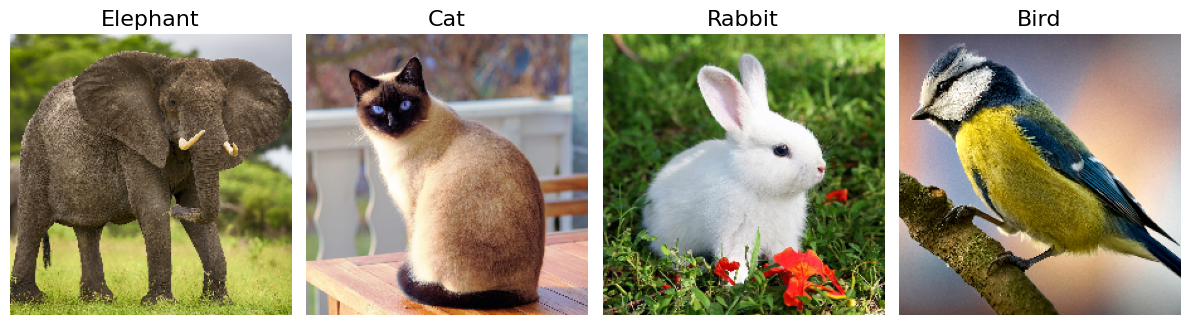

In [5]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

# Заголовки наших изображений
image_titles = ['Elephant', 'Cat', 'Rabbit', 'Bird']

# Загружаем изображения и конвертируем их в массив Numpy
img1 = load_img('elephant.jpg', target_size=(224, 224))
img2 = load_img('cat.jpg', target_size=(224, 224))
img3 = load_img('rabbit.jpeg', target_size=(224, 224))
img4 = load_img('bird.jpeg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4)])

# Подготавливаем входы для VGG16
X = preprocess_input(images)

# Выводим
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

Когда функция активации softmax применяется к последнему слою модели, это может препятствовать созданию изображений внимания, поэтому следует заменить эту функцию на функцию линейной активации.
Хотя здесь мы создаем и используем экземпляр ReplaceToLinear, мы также можем использовать функцию модификатора модели, определенную нами.

In [6]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

**Шаг 4**
**Функция расчета**. В данном шаге мы создаем экземпляр Score или определяем score function, которая возвращает целевые баллы. Здесь они возвращают количество очков, соответствующее слону, кошке, кролику и птице.

In [7]:
from tf_keras_vis.utils.scores import CategoricalScore

score = CategoricalScore([386, 285, 330, 134])
# Где: 386 - слон, 285 - кошка, 330 - кролик, 134 - птица

# Вместо использования объекта CategoricalScore
# определим функцию с нуля следующим образом:
def score_function(output):
    # Переменная `output` ссылается на выходы модели,
    # таким образом, что размерность `output` равна `(3, 1000)` где, (номер примера, номер класса)
    return (output[0][386], output[1][285], output[2][330], output[3][134])

**Шаг 5**
**Ванильная значимость.** Saliency генерирует карту значимости, на которой отображаются области входного изображения, которые имеют наибольшее влияние на выходное значение.

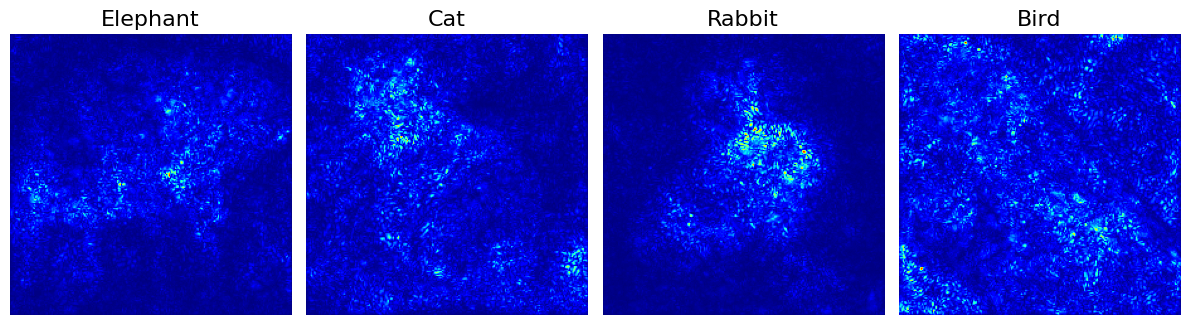

CPU times: user 5.08 s, sys: 1.61 s, total: 6.69 s
Wall time: 12.2 s


In [8]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Создаем объект внимания
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Генерируем карту внимания
saliency_map = saliency(score, X)

# Выводим
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

**Шаг 6**
**SmoothGrad.** Карта значимости Vanilla слишком шумная, поэтому следует удалить шум на карте значимости с помощью SmoothGrad. SmoothGrad — это метод, который уменьшает шум на карте значимости путем добавления шума к входному изображению.

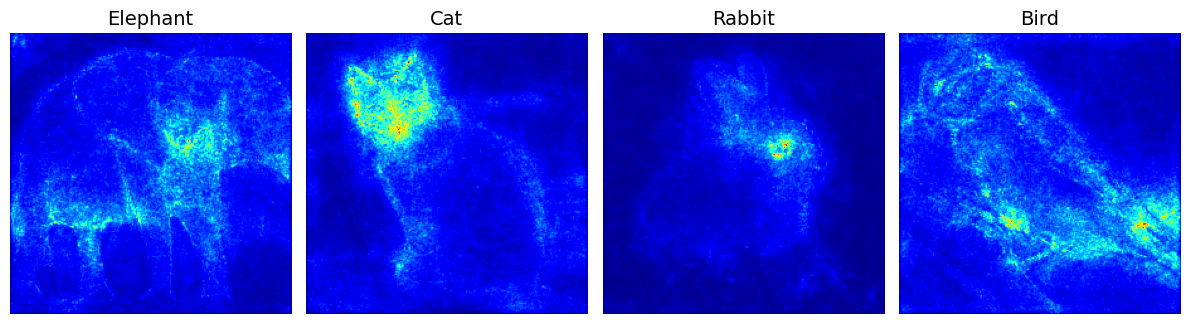

CPU times: user 2.5 s, sys: 196 ms, total: 2.7 s
Wall time: 3.81 s


In [9]:
%%time

# Генерируем карту внимания со сглаживанием, которое уменьшает шум за счет добавления шума
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # Количество итераций расчета градиентов
                        smooth_noise=0.20) # уровень распространения шума

# Выводим
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('smoothgrad.png')
plt.show()

**Шаг 7**
**Визуализация тепловой карты - GradCAM.** Вместо использования градиентов выходных данных модели он использует выходные данные предпоследнего слоя (то есть сверточного слоя непосредственно перед плотными слоями).
Функция визуализации GradCam получает 4 аргумента: model это изученная модель, X это пустой массив предварительно обработанных входных изображений, image_titles это соответствующие имена классов изображений в X, images это пустой массив исходных входных изображений.

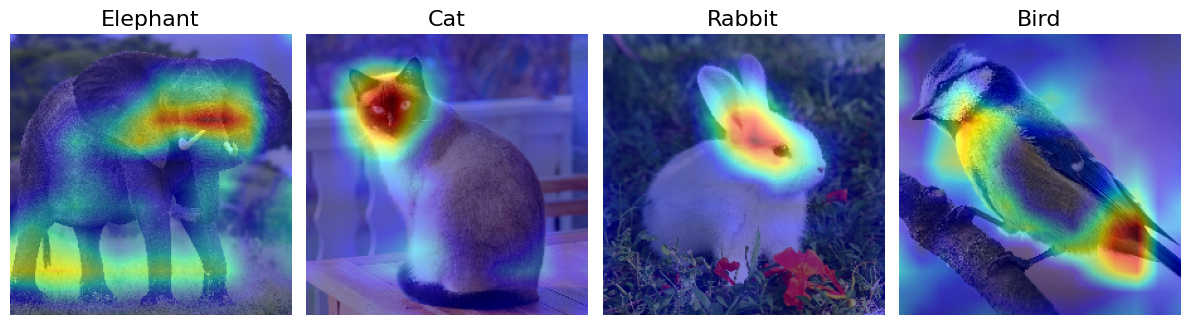

CPU times: user 1.84 s, sys: 836 ms, total: 2.67 s
Wall time: 2.73 s


In [10]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Создаём объект визуализации Gradcam
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Генерируем тепловую карту с помощью GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

# Выводим
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

Как видно, тепловые пятна не полностью покрывают цель на изображениях. В следующем шаге-методе, мы решим эту проблему.
**penultimate_layer**. Как видно, на данном шаге создания карты появился новый аргумент. Здесь предпоследний слой — это сверточный слой, ближайший к плотным слоям. Выходные данные этого слоя — это то, откуда GradCam получает градиенты.

**Шаг 8**
GradCam++ — улучшенная версия GradCam. Этот метод может обеспечить лучшее визуальное объяснение прогнозов модели CNN.

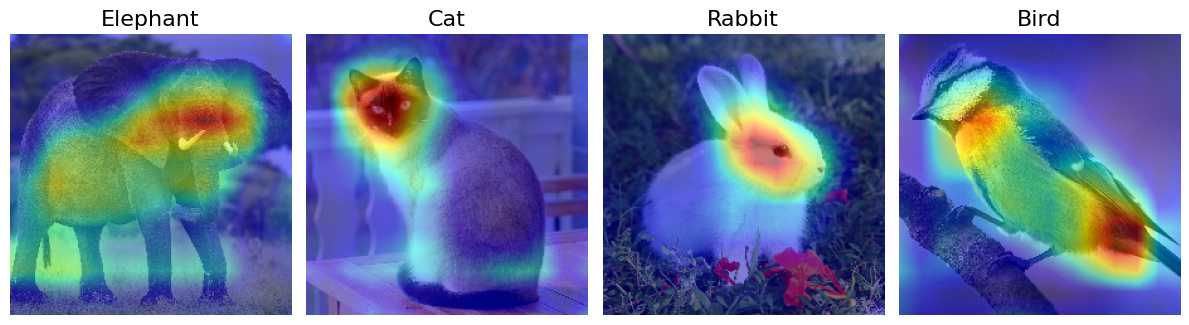

CPU times: user 2.35 s, sys: 726 ms, total: 3.08 s
Wall time: 3.61 s


In [11]:
%%time

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Создаем объект GradCAM++
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)
# Генерируем тепловую карту с помощью GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)
# Визуализируем
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('gradcam_plus_plus.png')
plt.show()

**Заключение**: Как мы можем видеть выше, тепловые пятна покрывают целевые объекты. В общем, лабораторная работа была выполнена успешно и были изучены полезные методы.